#**1. Prepare the Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
training_zip_file = '/content/drive/My Drive/1327317/train.zip'
test_zip_file = '/content/drive/My Drive/1327317/test.zip'
dataset_base_path = '/content/drive/My Drive/1327317/'

# Unzip the dataset
!unzip -q "$training_zip_file" -d "$dataset_base_path"
!unzip -q "$test_zip_file" -d "$dataset_base_path"

#**2. Preprocess Data**

In [3]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Load and preprocess images
data_info = pd.read_csv(os.path.join(dataset_base_path, 'training_set_pixel_size_and_HC.csv'))
all_images = []
circumferences = []

for index, record in data_info.iterrows():
    img_path = os.path.join(dataset_base_path, 'training_set', record['filename'])
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        resized_image = cv2.resize(image, (800, 540))
        all_images.append(resized_image)
        circumferences.append(record['head circumference (mm)'])

if not all_images:
    raise Exception("No images found. Verify paths.")

all_images = np.array(all_images, dtype='float32').reshape(-1, 800, 540, 1) / 255.0
circumferences = np.array(circumferences, dtype='float32')

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(all_images, circumferences, test_size=0.2, random_state=42)

print(f"Successfully loaded and split {len(all_images)} images.")


Successfully loaded and split 999 images.


#**3. Model**

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(800, 540, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=['mae'])

In [5]:
# Train
train_hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
25/25 [==============================] - 366s 15s/step - loss: 5469.7158 - mae: 54.1730 - val_loss: 1990.4656 - val_mae: 36.2223
Epoch 2/10
25/25 [==============================] - 374s 15s/step - loss: 1851.6135 - mae: 33.3012 - val_loss: 1595.3181 - val_mae: 31.1114
Epoch 3/10
25/25 [==============================] - 369s 15s/step - loss: 1369.5084 - mae: 28.5986 - val_loss: 1423.1332 - val_mae: 28.6293
Epoch 4/10
25/25 [==============================] - 341s 14s/step - loss: 1045.6451 - mae: 25.0872 - val_loss: 1740.1321 - val_mae: 31.5354
Epoch 5/10
25/25 [==============================] - 344s 14s/step - loss: 873.8945 - mae: 22.6443 - val_loss: 1264.0117 - val_mae: 26.9228
Epoch 6/10
25/25 [==============================] - 361s 15s/step - loss: 651.0488 - mae: 19.6169 - val_loss: 1295.9248 - val_mae: 26.7342
Epoch 7/10
25/25 [==============================] - 366s 15s/step - loss: 461.9550 - mae: 16.3637 - val_loss: 1325.9152 - val_mae: 27.0960
Epoch 8/10
25/25 [=====

#**4. Evaluation**

In [6]:
# Evaluation
val_mae = model.evaluate(X_val, y_val)[1]
print(f"Validation MAE: {val_mae}")

7/7 [==============================] - 22s 3s/step - loss: 1300.1119 - mae: 27.2222
Validation MAE: 27.222150802612305


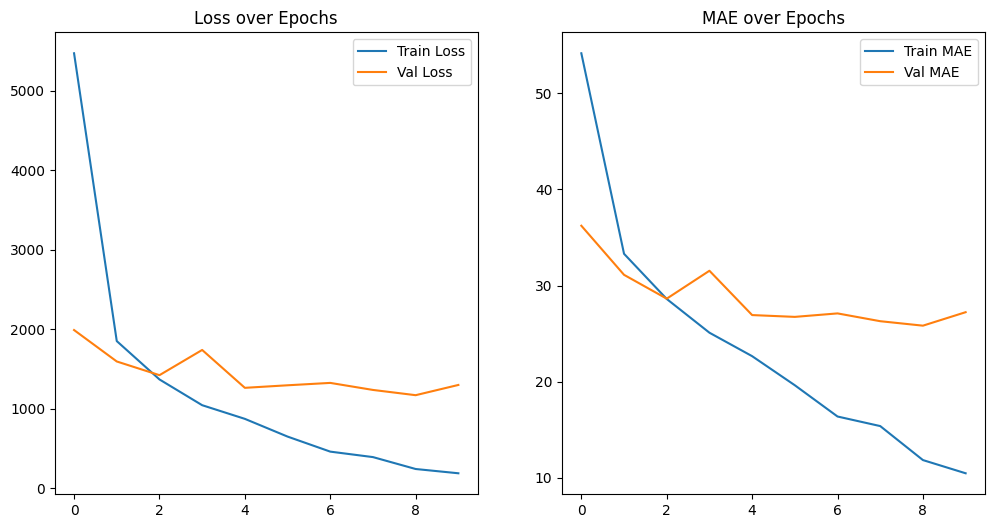

In [7]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='Train Loss')
plt.plot(train_hist.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(122)
plt.plot(train_hist.history['mae'], label='Train MAE')
plt.plot(train_hist.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.show()

7/7 [==============================] - 22s 3s/step


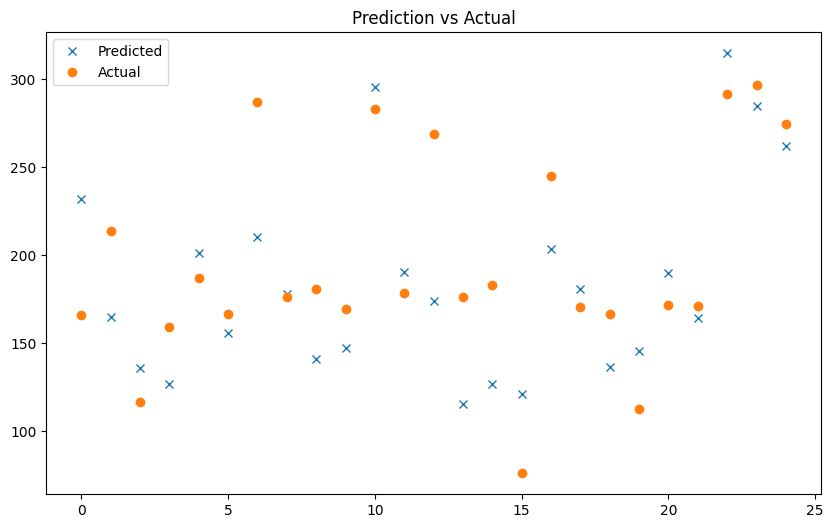

Number of predictions: 200


In [8]:
# Prediction vs. Ground Truth Visualization**

predictions = model.predict(X_val).flatten()

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(predictions[:25], 'x', label='Predicted')
plt.plot(y_val[:25], 'o', label='Actual')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

print(f"Number of predictions: {len(predictions)}")

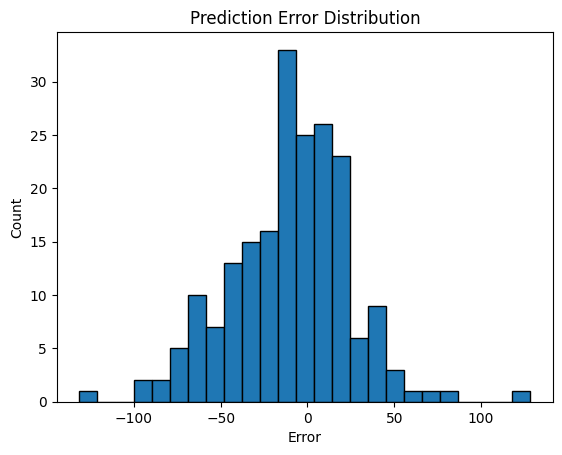

Mean Absolute Error: 27.22 mm


In [9]:
# Error Analysis
errors = predictions - y_val
plt.hist(errors, bins=25, edgecolor='black')
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

print(f"Mean Absolute Error: {np.mean(np.abs(errors)):.2f} mm")